<h1 style="font-family:verdana;"> <center>G2Net - Baseline Model</center> </h1>

***
## Competition overview
Finding consistent gravitational-wave signals is the aim of this repository. We'll create a model that is sensitive enough to distinguish between noisy data and the weak but persistent signals emitted by swiftly rotating neutron stars.

In this competition, we are given a training set for this competition that contains time-frequency data from two gravitational-wave interferometers (LIGO Hanford & LIGO Livingston). Each data sample has real or simulated noise, as well as perhaps a continuous simulated gravitational-wave signal (CW). Detecting the presence of a signal in the data is the task (target = 1).

In this notebook we will train a simple baseline model similar to [Basic spectrogram image classification](https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification). We train a straightforward EfficientNetB3 with the time-averaged power spectrum as input images. 360 x 360.

The TF records used in this notebook is taken from [G2Net - Record Generation](https://www.kaggle.com/code/morodertobias/g2net-record-generation).


In [1]:
## Import Libraries
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '4'
import re
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
print(tf.__version__)
from pydantic import BaseModel
from sklearn.model_selection import train_test_split

2.6.4


In [2]:
## List Devices on the machine
sorted(tf.config.list_logical_devices())

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
## Using TPU
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    print("TPU in use!")
except:
    strategy = tf.distribute.get_strategy()
print("Strategy:", strategy)
print("Number of replicas:", strategy.num_replicas_in_sync)

Strategy: <tensorflow.python.distribute.distribute_lib._DefaultDistributionStrategy object at 0x7f60ba730590>
Number of replicas: 1


In [4]:
from kaggle_datasets import KaggleDatasets

# Config

In [5]:
## Configurations
class Config(BaseModel):
    seed = 887
    # defines the model name and model directory
    model_name = "enetb3_v1"
    model_dir = "/kaggle/working/model"
    # defines the path to the GCS bucket where the training and test data are stored.
    gcs = KaggleDatasets().get_gcs_path("360-g2net-record-generation")
    path_submission = "/kaggle/input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv"
    train_dir = gcs + "/train/"
    test_dir = gcs + "/test/"
    # defines the image size, number of channels, and the shape of the input image.
    img_size = (360, 360)
    channels = 2
    img_shape = (*img_size, channels)
    # defines the base model weights, dropout, shuffle size, number of epochs, batch size, test batch size, learning rate, and patience.
    base_model_weights = "imagenet"
    dropout = 0.2
    # training
    shuffle_size = 128
    epochs = 200
    batch_size = 16 * strategy.num_replicas_in_sync
    test_batch_size = 64
    lr = 0.001
    patience = 10
    
cfg = Config()
cfg.dict()

{'seed': 887,
 'model_name': 'enetb3_v1',
 'model_dir': '/kaggle/working/model',
 'gcs': 'gs://kds-1abb01260782a886928b0c29c7209788eceeb508869589b38989c0b5',
 'path_submission': '/kaggle/input/g2net-detecting-continuous-gravitational-waves/sample_submission.csv',
 'train_dir': 'gs://kds-1abb01260782a886928b0c29c7209788eceeb508869589b38989c0b5/train/',
 'test_dir': 'gs://kds-1abb01260782a886928b0c29c7209788eceeb508869589b38989c0b5/test/',
 'img_size': (360, 360),
 'channels': 2,
 'img_shape': (360, 360, 2),
 'base_model_weights': 'imagenet',
 'dropout': 0.2,
 'shuffle_size': 128,
 'epochs': 200,
 'batch_size': 16,
 'test_batch_size': 64,
 'lr': 0.001,
 'patience': 10}

# Prepare data

Prepare training, validation and test datasets.

In [6]:
## Count Data Items
def count_data_items(filenames):
    n = [int(re.compile(r"size-([0-9]*)\.").search(f).group(1)) for f in filenames]
    return np.sum(n)

In [7]:
train_files = sorted(tf.io.gfile.glob(cfg.train_dir + "*.tfrec"))
train_files, valid_files = train_test_split(train_files, random_state=cfg.seed)
test_files = sorted(tf.io.gfile.glob(cfg.test_dir + "*.tfrec"))
count_data_items(train_files), train_files, count_data_items(valid_files), valid_files, count_data_items(test_files), len(test_files)

(1527,
 ['gs://kds-1abb01260782a886928b0c29c7209788eceeb508869589b38989c0b5/train/g2net-train-orig_shard-3_size-170.tfrec',
  'gs://kds-1abb01260782a886928b0c29c7209788eceeb508869589b38989c0b5/train/g2net-train-orig_shard-5_size-170.tfrec',
  'gs://kds-1abb01260782a886928b0c29c7209788eceeb508869589b38989c0b5/train/g2net-train-orig_shard-10_size-169.tfrec',
  'gs://kds-1abb01260782a886928b0c29c7209788eceeb508869589b38989c0b5/train/g2net-train-orig_shard-0_size-170.tfrec',
  'gs://kds-1abb01260782a886928b0c29c7209788eceeb508869589b38989c0b5/train/g2net-train-orig_shard-4_size-170.tfrec',
  'gs://kds-1abb01260782a886928b0c29c7209788eceeb508869589b38989c0b5/train/g2net-train-orig_shard-11_size-169.tfrec',
  'gs://kds-1abb01260782a886928b0c29c7209788eceeb508869589b38989c0b5/train/g2net-train-orig_shard-2_size-170.tfrec',
  'gs://kds-1abb01260782a886928b0c29c7209788eceeb508869589b38989c0b5/train/g2net-train-orig_shard-7_size-169.tfrec',
  'gs://kds-1abb01260782a886928b0c29c7209788eceeb508869

## Data handling

The tensorflow records have the stacked image encoded as tensor; so in particular not normalized to fit the default image ranges. A target is present in the training data, an id in the test data.


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
 

## Normalize Similar to Image
def normalize_as_image(x):
    t_min = tf.math.reduce_min(x, axis=[0, 1])
    t_max = tf.math.reduce_max(x, axis=[0, 1])
    img = (x - t_min) / (t_max - t_min) * 255.
    return img

## Decode Image
def decode_image(img_data):
    img = tf.io.parse_tensor(img_data, tf.float32)
    # channel first to last position
    img = tf.transpose(img, perm=[1, 2, 0])
    # normalize as float image in range [0. 255.]
    img = normalize_as_image(img)
    return img

## Parse Train TFRecord
##  The parse_train_tfrecord function parses the serialized data into a dictionary of features.
def parse_train_tfrecord(data):
    #  define a dictionary of features.
    features = {
        'img': tf.io.FixedLenFeature([], tf.string),
        'target': tf.io.FixedLenFeature([], tf.int64)
    }
    ## The features dictionary defines the names and types of the features of the dataset.
    ex = tf.io.parse_single_example(data, features)
    img = decode_image(ex["img"])
    return img, ex["target"]

## Parse Test TFRecord
## The parse_test_tfrecord function parses the serialized data into a dictionary of features.
def parse_test_tfrecord(data):
    features = {
        'img': tf.io.FixedLenFeature([], tf.string),
        'id': tf.io.FixedLenFeature([], tf.string)
    }
    ex = tf.io.parse_single_example(data, features)
    img = decode_image(ex["img"])
    return img, ex["id"]


def load_dataset(filenames, parse_func, ordered=False):
    #  Create a dataset from the TFRecord files.
    ds = tf.data.TFRecordDataset(filenames=filenames, num_parallel_reads=AUTOTUNE)
    # Apply the tf.data.Options context manager to the dataset.
    opt = tf.data.Options()
    # Use the experimental_deterministic option to make sure the data is produced in a deterministic way.
    opt.experimental_deterministic = ordered
    ds = ds.with_options(opt)
    # Map the parse_tfrecord function to each TFRecord in the dataset.
    ds = ds.map(parse_func, num_parallel_calls=AUTOTUNE)
    return ds

In [9]:
## Load the training dataset from the TFRecord files.
def get_training_dataset(filenames):
    ds = load_dataset(filenames, parse_func=parse_train_tfrecord, ordered=False)
    ds = ds.repeat()
    ds = ds.shuffle(cfg.shuffle_size)
    ds = ds.batch(cfg.batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

## Load the validation dataset from the TFRecord files.
def get_validation_dataset(filenames):
    ds = load_dataset(filenames, parse_func=parse_train_tfrecord, ordered=True)
    ds = ds.batch(cfg.batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

## Load the test dataset from the TFRecord files.
def get_test_dataset(filenames):
    ds = load_dataset(filenames, parse_func=parse_test_tfrecord, ordered=True)
    ds = ds.batch(cfg.test_batch_size)
    ds = ds.prefetch(AUTOTUNE)
    return ds

In [10]:
train_ds = get_training_dataset(train_files)
valid_ds = get_validation_dataset(valid_files)
test_ds = get_test_dataset(test_files)

#### Check dataset

In [11]:
imgs, labels = next(iter(train_ds))
imgs.shape, imgs.dtype, labels.shape, labels.dtype

(TensorShape([16, 360, 360, 2]), tf.float32, TensorShape([16]), tf.int64)

In [12]:
labels[:10]

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([1, 1, 0, 0, 0, 1, 1, 0, 1, 1])>

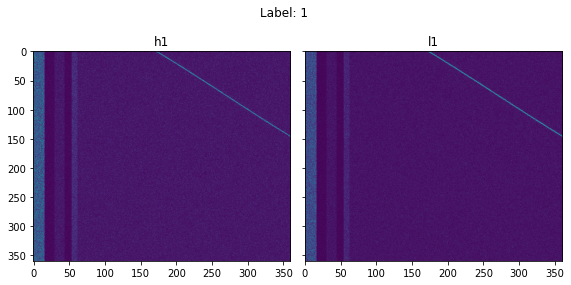

In [13]:
idx = 0
fig, axs = plt.subplots(ncols=2, figsize=(8, 4), sharey='all')
fig.suptitle(f"Label: {labels[idx].numpy()}")
kwargs_imshow = dict(aspect='auto', vmin=0.0, vmax=255.)
axs[0].imshow(imgs[idx][..., 0], **kwargs_imshow)
axs[0].set_title("h1")
axs[1].imshow(imgs[idx][..., 1], **kwargs_imshow)
axs[1].set_title("l1")
plt.tight_layout()
plt.show()

# Neural network

The pretrained TF model cannot directly handle 2 input channels (in contrast to ``timm`` as in [Basic spectrogram image classification](https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification)). Thus a prio ``1x1`` convolution is used to create a 3 channel input, similar as in [G2Net TF-Keras Train-Test With TPU](https://www.kaggle.com/code/itsuki9180/g2net-tf-keras-train-test-with-tpu).

In this notebook we are using EfficientB3 with 360x360 input images. The model is trained with the Adam optimizer and the binary crossentropy loss function. The learning rate is set to 1e-4 and the model is trained for 10 epochs.

EfficientNet is a convolutional neural network design and scaling technique that uses a compound coefficient to consistently scale all depth, breadth, and resolution parameters. The EfficientNet scaling approach evenly scales network breadth, depth, and resolution using a set of preset scaling coefficients, in contrast to standard practise, which scales these variables arbitrarily. For instance, to employ times more computing power, we may simply raise the network depth, width, and image size, where and are constant coefficients discovered via a tiny grid search on the initial small model. Network width, depth, and resolution are all uniformly scaled by EfficientNet using a compound coefficient.

In [14]:
from tensorflow.keras.applications.efficientnet import EfficientNetB3 as BaseModel
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, Model, Input, losses, metrics, optimizers, callbacks

In [15]:
## Unfreeze model
### Here we unfreeze the base model and freeze the BatchNormalization layers.
def unfreeze_model(model):
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False


def create_model():    
    # Input   
    inputs = Input(shape=cfg.img_shape, dtype=tf.float32)
    x = layers.Conv2D(3, 1, name='adjustment')(inputs)
    x = layers.Lambda(preprocess_input, name="preprocess_input")(x)
    base_model = BaseModel(include_top=False, weights=cfg.base_model_weights, pooling="avg")
    base_model.trainable = False
    # unfreeze_model(base_model)
    x = base_model(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(cfg.dropout, name="top_dropout")(x)
    outputs = layers.Dense(1, activation="sigmoid", name="logits")(x)
    model = Model(inputs=inputs, outputs=outputs, name=cfg.model_name)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=cfg.lr),
        loss=losses.BinaryCrossentropy(), 
        metrics=['acc']
    )
    return model

In [16]:
tf.keras.backend.clear_session()
with strategy.scope():
    model = create_model()
model.summary()

43950080/43941136 [==============================] - 0s 0us/step
Model: "enetb3_v1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 360, 360, 2)]     0         
_________________________________________________________________
adjustment (Conv2D)          (None, 360, 360, 3)       9         
_________________________________________________________________
preprocess_input (Lambda)    (None, 360, 360, 3)       0         
_________________________________________________________________
efficientnetb3 (Functional)  (None, 1536)              10783535  
_________________________________________________________________
batch_normalization (BatchNo (None, 1536)              6144      
_________________________________________________________________
top_dropout (Dropout)        (None, 1536)              0         
__________________________________________________________

#### Check model

In [17]:
## Generates output predictions for the input samples.
model.predict(imgs)[:10]

array([[0.35648742],
       [0.53010625],
       [0.4232769 ],
       [0.39307195],
       [0.5253041 ],
       [0.53098667],
       [0.52689224],
       [0.52463555],
       [0.3943216 ],
       [0.5296742 ]], dtype=float32)

In [18]:
## Returns the loss value & metrics values (Accuracy) for the model in test mode.
model.evaluate(imgs, labels, return_dict=True)

1/1 [==============================] - 3s 3s/step - loss: 0.7082 - acc: 0.5000


{'loss': 0.7082251310348511, 'acc': 0.5}

# Training

In [19]:
def get_callbacks():
    cbs = [
        callbacks.EarlyStopping(
            monitor="val_loss",
            verbose=1,
            patience=cfg.patience,
            restore_best_weights=True,
        ),
    ]
    return cbs
##  The EarlyStopping callback is a standard callback that stops training when the validation loss has not improved for a specified number
##  of epochs and restores the best weights found during training.

def show_history(history):
    history_frame = pd.DataFrame(history.history)
    history_frame.index = pd.RangeIndex(1, len(history_frame) + 1, name="epoch")
    display(history_frame.style\
        .highlight_min(color='lightgreen', subset=['val_loss'])\
        .highlight_max(color='lightgreen', subset=['val_acc'])
    )
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    history_frame.loc[:, ['loss', 'val_loss']].plot(ax=ax[0], title='loss')
    history_frame.loc[:, ['acc', 'val_acc']].plot(ax=ax[1], title='acc')
    plt.tight_layout()
    plt.show()

In [20]:
## Steps per epoch
train_steps = count_data_items(train_files) // cfg.batch_size
print("steps per epoch:", train_steps)

steps per epoch: 95


In [21]:
%%time
history = model.fit(
    train_ds, 
    epochs=cfg.epochs,
    steps_per_epoch=train_steps,
    validation_data=valid_ds,
    callbacks=get_callbacks(),
    verbose=1
)

Epoch 1/200
95/95 [==============================] - 77s 643ms/step - loss: 0.5288 - acc: 0.7454 - val_loss: 0.5543 - val_acc: 0.7850
Epoch 2/200
95/95 [==============================] - 56s 590ms/step - loss: 0.4900 - acc: 0.7730 - val_loss: 0.5041 - val_acc: 0.7811
Epoch 3/200
95/95 [==============================] - 48s 508ms/step - loss: 0.5002 - acc: 0.7572 - val_loss: 0.5008 - val_acc: 0.7870
Epoch 4/200
95/95 [==============================] - 45s 479ms/step - loss: 0.4928 - acc: 0.7737 - val_loss: 0.4663 - val_acc: 0.7890
Epoch 5/200
95/95 [==============================] - 44s 468ms/step - loss: 0.4577 - acc: 0.7961 - val_loss: 0.4638 - val_acc: 0.7890
Epoch 6/200
95/95 [==============================] - 52s 547ms/step - loss: 0.4658 - acc: 0.7882 - val_loss: 0.4531 - val_acc: 0.7909
Epoch 7/200
95/95 [==============================] - 44s 463ms/step - loss: 0.4758 - acc: 0.7763 - val_loss: 0.4554 - val_acc: 0.7949
Epoch 8/200
95/95 [==============================] - 52s 549ms

,loss,acc,val_loss,val_acc
epoch,,,,
1,0.528806,0.745395,0.554313,0.785010
2,0.489955,0.773026,0.504085,0.781065
3,0.500215,0.757237,0.500842,0.786982
4,0.492841,0.773684,0.466285,0.788955
5,0.457748,0.796053,0.463797,0.788955
6,0.465809,0.788158,0.453119,0.790927
7,0.475838,0.776316,0.455379,0.794872
8,0.463895,0.774342,0.460315,0.792899
9,0.462177,0.782237,0.450361,0.796844


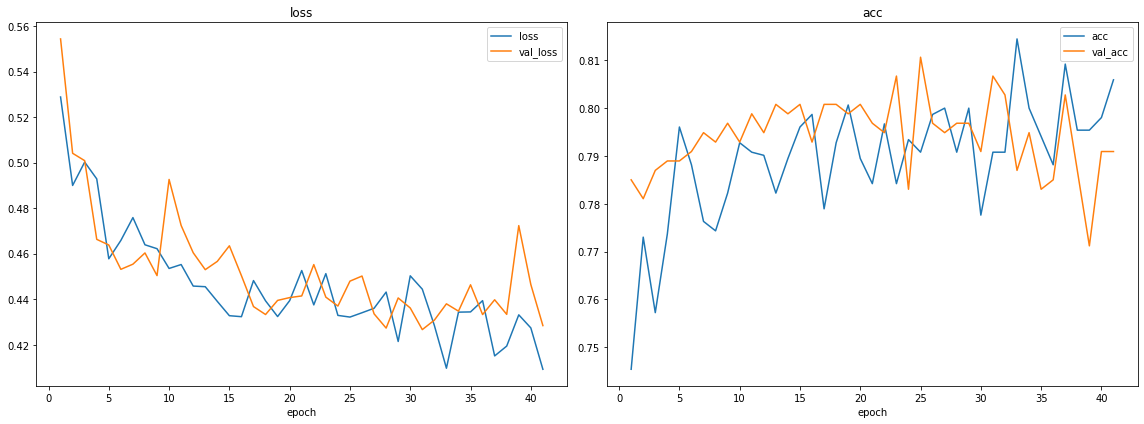

In [22]:
show_history(history)

In [23]:
model.save(cfg.model_dir)
os.listdir(cfg.model_dir)

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


['keras_metadata.pb', 'variables', 'saved_model.pb', 'assets']

# Test

Predict on test dataset.

In [24]:
test_ids = np.concatenate([x.numpy() for x in test_ds.map(lambda imgs, ids: ids)])
test_ids

array([b'00054c878', b'0007285a3', b'00076c5a6', ..., b'20e1dbc67',
       b'20f826e8f', b'20f85a935'], dtype=object)

In [25]:
preds = model.predict(test_ds, verbose=1)

125/125 [==============================] - 147s 1s/step


In [26]:
submission = pd.DataFrame({
    "id": test_ids,
    "target": preds.ravel()
})
submission["id"] = submission["id"].str.decode('utf-8')
submission = submission.sort_values(by="id")
submission = submission.reset_index(drop=True)
submission

,id,target
0,00054c878,0.265166
1,0007285a3,0.284305
2,00076c5a6,0.260120
3,001349290,0.184162
4,001a52e92,0.379040
...,...,...
7970,ffbce04ef,0.330592
7971,ffc2d976b,0.244992
7972,ffc905909,0.345997
7973,ffe276f3e,0.316729


#### Check submission

In [27]:
sample_submission = pd.read_csv(cfg.path_submission)
(sample_submission["id"] == submission["id"]).all()

True

In [28]:
submission["target"].describe()

count    7975.000000
mean        0.447253
std         0.274064
min         0.054810
25%         0.266867
50%         0.324583
75%         0.461509
max         0.999983
Name: target, dtype: float64

View distribution

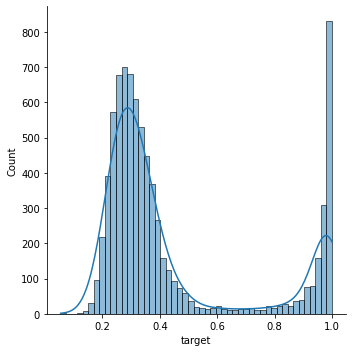

In [29]:
sns.displot(submission, x="target", kde=True)

## Write submission

In [30]:
submission.to_csv("submission.csv", index=False)

In [31]:
!head submission.csv

id,target
00054c878,0.26516563
0007285a3,0.28430477
00076c5a6,0.26012024
001349290,0.18416195
001a52e92,0.3790397
00222d97b,0.2735235
00249c302,0.26843703
0026862ce,0.25575513
00368b973,0.25121266


### References
 - [G2Net TF Baseline 360](https://www.kaggle.com/code/crischir/g2net-tf-baseline-360)
 - [Basic Spectrogram image classification](https://www.kaggle.com/code/junkoda/basic-spectrogram-image-classification)
 - [G2Net TF Keras train test with TPU](https://www.kaggle.com/code/itsuki9180/g2net-tf-keras-train-test-with-tpu)

## End of the Notebook